Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Imports

In [ ]:
## General
import time
import numpy as np
#from collections import deque
import functools
from jax import random
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import jit, pmap

##import jax.tools.colab_tpu

import pickle
import tempfile

#from typing import Any, Dict, Iterable, List, Optional, Tuple, Union

## Data Pipeline
#import os
from dataclasses import dataclass
import tensorflow as tf
import tensorflow_datasets as tfds
AUTOTUNE = tf.data.experimental.AUTOTUNE
#import tensorflow_text as tftxt

#import bert_vocab_from_dataset as bert_vocab

#Brain
from flax import linen as nn

## Training Loop
import optax
from flax.training import train_state
from flax import jax_utils

In [ ]:
## Test TPUs
print(f'Found {jax.device_count()} devices')
#jax.devices()

Found 8 devices


# Binary Bitstring Dataset

In [ ]:
@dataclass
class DevSplit:
  num_dev: int
  seq_len: int
  name: str = 'bitstring'
  def __call__(self, features):
    return {
        k: tf.reshape(v, [num_dev, -1, seq_len]) if k == self.name else tf.reshape(v, [num_dev, -1])
        for k, v in features.items()
    }

In [ ]:
def get_preprocess_fn(num_dev, seq_len):
  return preprocess_spec.PreprocessFn([ DevSplit(num_dev, seq_len) ],
    only_jax_types=False)

In [ ]:
def get_dataset(cfg, key):
  """ cfg: dict contains:
    num_steps: lines per epoch
    seq_len: number of tokens per sequence
    dtype
    batch_size
    prefetch_size: prefetches this many batches
  """
  data = random.randint(key, (cfg['num_steps'], cfg['seq_len']), 0, 2, dtype=cfg['dtype'])
  labels = (data.sum(axis=1) % 2 == 0).astype(data.dtype)

  ds = tf.data.Dataset.from_tensor_slices({"bitstring":data, "even":labels})
  ds = ds.batch(cfg['batch_size'], drop_remainder=True, num_parallel_calls=AUTOTUNE)
  ds = ds.prefetch(cfg['prefetch_size'])

  dev_splitter = DevSplit(cfg['num_dev'], cfg['seq_len'])
  ds = ds.map(dev_splitter, num_parallel_calls=AUTOTUNE)

  ds = ds.cache()
  return tfds.as_numpy(ds)

# Brain

In [ ]:
#@functools.partial(jit, static_argnums=(1,2))
def mps_norm_sq(params, n_cores, partial_len):
  """
  Cores have shape (vocab, bond_dim**2),
  except first/last, which have shape (vocab, bond_dim)
  """
  vocab, bond_dim = params['core_0']['embedding'].shape
  top_list = [params[f'core_{i}']['embedding'] for i in range(n_cores)]
  bot_list = top_list.copy()

  Tcore = top_list[0]
  Bcore = bot_list[0]
  cap = jnp.matmul(Bcore.T, Tcore).reshape(1, bond_dim, bond_dim)
  log_norm = 0.0

  for i in range(1,n_cores-1):
    CTcore = jnp.matmul(cap, top_list[i].reshape(vocab, bond_dim, bond_dim)).reshape(-1, bond_dim)
    Bcore = bot_list[i].reshape(-1, bond_dim)
    cap = jnp.matmul(Bcore.T, CTcore).reshape(1, bond_dim, bond_dim)
    #cap = (cap + cap.transpose(0,2,1))/2
    #if i % partial_len == 0:
    cap_norm = jnp.linalg.norm(cap)
    log_norm += jnp.log(cap_norm)
    cap /= cap_norm

  Tcore = jnp.matmul(top_list[-1], cap).reshape(-1)
  Bcore = bot_list[-1].reshape(-1)
  log_norm += jnp.log(jnp.matmul(Bcore, Tcore))

  return log_norm

In [ ]:
## Modified "variance_scaling" function from Jax
def unit_embed_init(key, shape, dtype=jnp.float_):
  tot_shape = 1
  for s in shape: tot_shape *= s
  fan_in = tot_shape / shape[-1]
  variance = jnp.array(1.0 / fan_in, dtype=dtype)

  embeds = random.normal(key, shape, dtype) #* jnp.sqrt(variance)
  norms = jnp.linalg.norm(embeds, axis = -1)

  return embeds / norms[:,None]

def iden_embed_init(key, shape, dtype=jnp.float_):
  vocab_sqrt = np.sqrt(shape[0])
  bond_dim = np.sqrt(shape[1]).astype(int)

  base = np.identity(bond_dim).flatten() / vocab_sqrt
  embeds = random.normal(key, shape, dtype) * 1E-4
  return embeds + base

def orth_init(key, shape, dtype=jnp.float_):
  bond_dim = np.sqrt(shape[1]).astype(int)
  slice_list = []
  for slice in range(shape[0]):
    key, slice_key = jax.random.split(key)
    rand = random.normal(slice_key, (bond_dim, bond_dim), dtype)
    q,_ = jnp.linalg.qr(rand)
    slice_list.append(q.flatten())
  return jnp.stack(slice_list)

def rand_init(key, shape, dtype=jnp.float_):
  return random.normal(key, shape, dtype) * 0.5

In [ ]:
class MPS(nn.Module):
  ## Assume fixed length input sequences
  num_cores: int
  bond_dim: int
  vocab_size: int
  embed_dtype: jnp.dtype

  def setup(self):
    init = rand_init
    self.left_core = nn.Embed(self.vocab_size, self.bond_dim, name="core_0", embedding_init=init, dtype=self.embed_dtype)
    self.mid_core_list = [nn.Embed(self.vocab_size, self.bond_dim**2, name=f'core_{i+1}', embedding_init=init, dtype=self.embed_dtype) for i in range(self.num_cores-2)]
    self.right_core = nn.Embed(self.vocab_size, self.bond_dim, name=f"core_{self.num_cores-1}", embedding_init=init, dtype=self.embed_dtype)

  def __call__(self, x, partial_len):
    assert x.shape[-1] == len(self.mid_core_list) + 2

    contr_cores = [self.left_core(x[:,0]).reshape(-1, 1, self.bond_dim)]
    contr_cores += [core(x[:,i+1]).reshape(-1, self.bond_dim, self.bond_dim) for i, core in enumerate(self.mid_core_list)]
    contr_cores += [self.right_core(x[:,-1]).reshape(-1, self.bond_dim, 1)]

    log_scalar = jnp.zeros(x.shape[0], dtype=self.embed_dtype)
    while len(contr_cores) > 1:
      ## do partial_len contractions, then add the partial result to the log_scalar
      contr_len = min(partial_len, len(contr_cores)-1)
      for i in range(contr_len):
        Lcore = contr_cores.pop(0)
        contr_cores[0] = jnp.matmul(Lcore, contr_cores[0])
      norm = jnp.linalg.norm(contr_cores[0], axis=-1)
      log_scalar += jnp.log(norm).flatten()
      contr_cores[0] = contr_cores[0] / norm[:,None]
    
    return log_scalar

In [ ]:
def sampler(params, n_cores, key, precision=jax.lax.Precision.DEFAULT):
  """
  Cores have shape (vocab, bond_dim**2),
  except first/last, which have shape (vocab, bond_dim)
  """
  matmul = functools.partial(jnp.matmul, precision=precision)

  vocab, bond_dim = params['core_0']['embedding'].shape
  top_list = [params[f'core_{i}']['embedding'] for i in range(n_cores)]
  bot_list = top_list.copy()

  """
  Generate list of right caps (in reverse) and their log_norms
  """
  Tcore = top_list[-1]
  Bcore = bot_list[-1]

  cap = matmul(Bcore.T, Tcore).reshape(1, bond_dim, bond_dim)
  #cap = (cap + cap.transpose(0,2,1))/2
  cap_norm = jnp.linalg.norm(cap)
  cap /= cap_norm

  caps_rev = [cap]
  #log_norms_rev = [jnp.log(cap_norm)]

  for cap_i in range(1,n_cores-1):
    CTcore = matmul(top_list[-1-cap_i].reshape(vocab, bond_dim, bond_dim), caps_rev[-1])
    CTcore = CTcore.transpose(1,0,2).reshape(bond_dim, -1)

    Bcore = bot_list[-1-cap_i].reshape(vocab, bond_dim, bond_dim)
    Bcore = Bcore.transpose(0,2,1).reshape(-1, bond_dim)
    
    cap = matmul(CTcore, Bcore).reshape(1, bond_dim, bond_dim)
    #cap = (cap + cap.transpose(0,2,1))/2
    cap_norm = jnp.linalg.norm(cap)
    cap /= cap_norm
    caps_rev.append(cap)

    '''
    tot_log_cap_norm = jnp.log(cap_norm) + log_norms_rev[-1]
    log_norms_rev.append(tot_log_cap_norm)
    '''

  """
  Calculate MPS log norm squared
  """
  CTcore = matmul(top_list[0], caps_rev[-1])
  Bcore = bot_list[0]
  '''
  pre_norm = matmul(CTcore.reshape(-1), Bcore.reshape(-1))
  log_norm_sq = jnp.log(pre_norm) + log_norms_rev[-1]
  '''

  """
  find marginal distribution for site i, conditioned on sites 0 - i-1
  """
  pre_density = matmul(CTcore.reshape(bond_dim, bond_dim), Bcore.T)
  ##density = pre_density / pre_norm
  density = pre_density / jnp.trace(pre_density)
  key, samp_key = random.split(key)
  tok_list = [random.choice(samp_key, vocab, p=density.diagonal()).item()]

  print("Site 0")
  print(density)

  TLcore = top_list[0][tok_list[0]]
  BLcore = bot_list[0][tok_list[0]]

  for site_i in range(1,n_cores-1):
    print(f"\nSite {site_i}:")

    Tmidcore = top_list[site_i].reshape(vocab, bond_dim, bond_dim)
    Bmidcore = bot_list[site_i].reshape(vocab, bond_dim, bond_dim)

    Tcore = matmul(TLcore, Tmidcore)
    Bcore = matmul(BLcore, Bmidcore)

    cap = caps_rev[-(site_i+1)].reshape(bond_dim, bond_dim)
    CTcore = matmul(Tcore, cap)
    pre_density = matmul(CTcore, Bcore.T)
    ##density = pre_density * jnp.exp(log_norms_rev[-(site_i+1)] - log_norm_sq)
    density = pre_density / jnp.trace(pre_density)
    print(density)

    key, samp_key = random.split(key)
    tok_list.append( random.choice(key, vocab, p=density.diagonal()).item() )

    TLcore = matmul( TLcore, top_list[site_i][tok_list[-1]].reshape(bond_dim, bond_dim))
    BLcore = matmul( BLcore, bot_list[site_i][tok_list[-1]].reshape(bond_dim, bond_dim))

  top = matmul( TLcore, top_list[-1].T)
  bot = matmul( BLcore, bot_list[-1].T)
  pre_density = jnp.outer(top, bot)
  density = pre_density / jnp.trace(pre_density)
  print("\nFinal density")
  print(density)

  key, samp_key = random.split(key)
  tok_list.append( random.choice(key, vocab, p=density.diagonal()).item() )

  return tok_list

In [ ]:
optimizer = get_optim(tx_cfg, sched_cfg)

state = create_train_state(random.PRNGKey(16), mps_cfg, optimizer, input_dtype=jnp.int32)

In [ ]:
tokens = sampler(state.params, seq_len, random.PRNGKey(0), jax.lax.Precision.HIGHEST)
print("\nTokens:", tokens)

Site 0
[[0.97456163 0.14118709]
 [0.14118707 0.02543834]]

Site 1:
[[0.5794466  0.24951053]
 [0.24951048 0.4205533 ]]

Final density
[[ 0.14362578 -0.3507099 ]
 [-0.3507099   0.8563742 ]]

Tokens: [0, 0, 1]


# Training & Validation

In [ ]:
def loss_fn(log_outputs, log_norm_sq, alpha):
  return -jnp.mean( log_outputs - 0.5*log_norm_sq ) + alpha * log_norm_sq

def cross_ent(log_outputs, log_norm_sq, even_mask, alpha):
  evens_loss = -jnp.mean(log_outputs * even_mask[:,None])
  odd_probs = (log_outputs * (1-even_mask)[:,None]) - 0.5*log_norm_sq
  odds_loss = -jnp.mean( jnp.log(1 - jnp.exp(odd_probs)) )
  #odds_loss = jnp.mean(log_outputs * (1-even_mask)[:,None])
  return evens_loss + odds_loss + (1 + alpha)*log_norm_sq

def compute_metrics(sync_loss, sync_LNS, alpha):
  metric_loss = jax_utils.unreplicate(sync_loss)
  metric_LNS = jax_utils.unreplicate(sync_LNS)
  return {
      'loss' : metric_loss,
      'pred_loss' : metric_loss - alpha*metric_LNS,
      'log_norm_sq' : metric_LNS
  }

In [ ]:
## Training Loop
## N.B. pmap automatically jits its argument
@functools.partial(pmap, axis_name='num_devices', static_broadcasted_argnums=(2,3,4))
def train_step(state, batch, seq_len, alpha, partial_len):
  """Train for a single step."""
  def train_loss(params):
    log_outputs = state.apply_fn({'params': params}, batch['bitstring'], partial_len)
    log_norm_sq = mps_norm_sq(params, seq_len, partial_len)
    loss = cross_ent(log_outputs, log_norm_sq, batch['even'], alpha)
    return loss, log_norm_sq
  grad_fn = jax.value_and_grad(train_loss, has_aux=True)
  (p_loss, p_log_norm_sq), p_grads = grad_fn(state.params)

  sync_grads = jax.lax.pmean(p_grads, axis_name='num_devices')
  sync_loss = jax.lax.pmean(p_loss, axis_name='num_devices')

  state = state.apply_gradients(grads=sync_grads)
  """
  N.B. pmean syncs over devices, so we can just take the first element,
  which will be the same on each device in the ShardedDeviceArray
  """
  return state, sync_loss, p_log_norm_sq


def train_epoch(state, train_ds, seq_len, alpha, partial_len):
  """Train for a single epoch."""
  batch_metrics = []
  #i = 0
  for feat_batch in train_ds:
    state, sync_loss, sync_LNS = train_step(state, feat_batch, seq_len, alpha, partial_len)
    metrics = compute_metrics(sync_loss, sync_LNS, alpha)
    '''
    print(f"step {i :02}")
    for k,v in metrics.items():
      print(f"\t{k}: {v}")
    i+=1
    #'''
    batch_metrics.append(metrics)

    loss = metrics['loss']
    if np.isnan(loss) or np.isinf(loss):
      break

  # compute mean of metrics across each batch in epoch.
  batch_metrics_np = jax.device_get(batch_metrics)
  epoch_metrics_np = {
      k: np.mean([metrics[k] for metrics in batch_metrics_np])
      for k in batch_metrics_np[0]}

  return state, epoch_metrics_np

In [ ]:
## Validation Loop
@functools.partial(pmap, axis_name='num_devices', static_broadcasted_argnums=(3,4))
def eval_step(state, batch, log_norm_sq, alpha, partial_len):
  log_outputs = state.apply_fn({'params': state.params}, batch['bitstring'], partial_len)
  p_loss = cross_ent(log_outputs, log_norm_sq, batch['even'], alpha)
  return jax.lax.pmean(p_loss, axis_name='num_devices')


def eval_model(state, test_ds, seq_len, alpha, partial_len):
  log_norm_sq = jax_utils.replicate(mps_norm_sq(jax_utils.unreplicate(state.params), seq_len, partial_len))
  
  batch_metrics = []
  for feat_batch in test_ds:
    sync_loss = eval_step(state, feat_batch, log_norm_sq, alpha, partial_len)
    metrics = compute_metrics(sync_loss, log_norm_sq, alpha)
    batch_metrics.append(metrics)

  # compute mean of metrics across each batch in epoch.
  batch_metrics_np = jax.device_get(batch_metrics)
  epoch_metrics_np = {
      k: np.mean([metrics[k] for metrics in batch_metrics_np])
      for k in batch_metrics_np[0]}

  return epoch_metrics_np

# Parameter Optimization

In [ ]:
def warmup_constant_schedule(init_value=0.0001, end_value=0.01, warmup_steps=25000*10):
  schedules = [
      optax.linear_schedule(
          init_value=init_value,
          end_value=end_value,
          transition_steps=warmup_steps),
      optax.constant_schedule(end_value)
  ]
  return optax.join_schedules(schedules, [warmup_steps])

In [ ]:
def get_optim(tx_cfg, sched_cfg):
  scheduler = warmup_constant_schedule(**sched_cfg)
  if tx_cfg == None:
    return optax.sgd(learning_rate=scheduler)
  else:
    return optax.sgd(learning_rate=scheduler, **tx_cfg)
  '''
  return optax.chain(
    optax.clip(1.0),
    optax.sgd(learning_rate=scheduler, **tx_cfg)
  )#'''

In [ ]:
def create_train_state(rng, mps_cfg, optimizer, input_dtype=jnp.int32):
  """Creates initial `TrainState`."""
  mps = MPS(**mps_cfg)
  params = mps.init(rng, jnp.ones([1, mps_cfg['num_cores']], dtype=input_dtype), 1 )['params']
  #replicated_params = jax.tree_map(lambda x: jnp.array([x] * num_dev), params)
  return train_state.TrainState.create(apply_fn=mps.apply, params=params, tx=optimizer)

# Logging & Visualization

In [ ]:
'''
# Handy shortcut to create create async logging/tensorboard writer.
writer = metric_writers.create_default_writer(log_folder_id)
for step in range(10):
  writer.write_scalars(step, dict(loss=0.9**step))
'''

'\n# Handy shortcut to create create async logging/tensorboard writer.\nwriter = metric_writers.create_default_writer(log_folder_id)\nfor step in range(10):\n  writer.write_scalars(step, dict(loss=0.9**step))\n'

In [ ]:
#%tensorboard --logdir=./metrics --port=0

In [ ]:
'''
logging.set_verbosity(logging.INFO)
logdir = './metrics'
writer = metric_writers.create_default_writer(logdir)
'''

"\nlogging.set_verbosity(logging.INFO)\nlogdir = './metrics'\nwriter = metric_writers.create_default_writer(logdir)\n"

In [ ]:
'''
def get_prog_reporter(total_steps, report_freq, writer):
  return periodic_actions.ReportProgress(
      num_train_steps=total_steps,
      every_steps=report_freq,
      writer=writer)
'''

'\ndef get_prog_reporter(total_steps, report_freq, writer):\n  return periodic_actions.ReportProgress(\n      num_train_steps=total_steps,\n      every_steps=report_freq,\n      writer=writer)\n'

In [ ]:
def status_update(loop_name, metrics, dur):
  metric_string = f'{loop_name :8}'
  for k, v in metrics.items():
    metric_string += f"{k}: {v}; "
  print(metric_string)
  print(f'\tEpoch time: {dur :.2f} sec ({dur/3600 :.2f} hours)')

In [ ]:
'''
def gen_plot(data_list, x_label='Epoch', y_label='loss'):
  plt.style.use('seaborn-whitegrid')
  fig = plt.figure()
  ax = plt.axes()

  x = list(range(len(data_list)))
  plt.plot(x, data_list)

  plt.xlabel(x_label)
  plt.ylabel(y_label)
'''
def gen_plot(data_collection, x_label='Epoch', y_label='loss'):
  plt.style.use('seaborn-whitegrid')
  fig = plt.figure()
  ax = plt.axes()

  num_epochs = data_collection['num_epochs']
  x = list(range(num_epochs))

  for name, data in data_collection.items():
    if name != 'num_epochs':
      plt.plot(x, data[:num_epochs], label=name)

  plt.legend()
  plt.xlabel(x_label)
  plt.ylabel(y_label)

In [ ]:
def plot_lr(sched_fn, sched_cfg, num_epochs, epoch_len):
  scheduler = sched_fn(**sched_cfg)
  x = list(range(num_epochs))
  lr = []
  for epoch in x:
    lr.append(scheduler(epoch*epoch_len))

  plt.style.use('seaborn-whitegrid')
  fig = plt.figure()
  ax = plt.axes()
  plt.plot(x, lr)

  plt.xlabel("Epoch")
  plt.ylabel("Learning Rate")

# MAIN

In [ ]:
""" Config """
## Shared
num_dev = jax.local_device_count()
vocab_size = 2
seq_len = 3
unk = "[UNK]"
train_epoch_len = 2**20


## Dataset
train_ds_cfg = {
  "num_dev" : num_dev,
  "num_steps" : train_epoch_len,
  "batch_size" : num_dev*512,
  "seq_len" : seq_len,
  "dtype" : jnp.int32,
  "num_dev" : num_dev,
  "prefetch_size" : AUTOTUNE
}
test_ds_cfg = {
  "num_dev" : num_dev,
  "num_steps" : 2**17,
  "batch_size" : num_dev*512,
  "seq_len" : seq_len,
  "dtype" : jnp.int32,
  "num_dev" : num_dev,
  "prefetch_size" : AUTOTUNE
}


## Model
mps_cfg = {
    'num_cores': seq_len,
    'bond_dim' : 2,
    'vocab_size' : vocab_size,
    'embed_dtype' : jnp.float32
}
tx_cfg = {
    #'learning_rate' : 0.001,
    'momentum' : 0.9
}
sched_cfg = {
    'init_value' : 0.00001,
    'end_value' : 0.001,
    'warmup_steps' : train_epoch_len
}
'''
    'transition_steps' : train_epoch_len, ## "scale" of steps: decayed_value = init_value * decay_rate ^ (count / transition_steps)
    'decay_rate' : 0.999,
    'transition_begin' : 10*train_epoch_len, ## steps between warmup end and decay begin
    'staircase' : False,
    'end_value' : 0.0000001
'''

## Training
alpha = 0.4
partial_eval_len = 2

In [ ]:
key = random.PRNGKey(0)

key, train_key = random.split(key)
train_ds = get_dataset(train_ds_cfg, train_key)

key, test_key = random.split(key)
test_ds = get_dataset(test_ds_cfg, test_key)

In [ ]:
optimizer = get_optim(tx_cfg, sched_cfg)

state = create_train_state(random.PRNGKey(16), mps_cfg, optimizer, input_dtype=jnp.int32)
""" Efficient to replicate entire state? """
state = jax_utils.replicate(state)

' Efficient to replicate entire state? '

In [ ]:
## Pre-training evaluation

t0 = time.time()
pre_metrics = eval_model(state, test_ds, seq_len, alpha, partial_eval_len)
pre_dur = time.time() - t0
status_update('Init', pre_metrics, pre_dur)

Init    log_norm_sq: 4.971582412719727; loss: 7.716007232666016; pred_loss: 5.727374076843262; 
	Epoch time: 0.66 sec (0.00 hours)


In [ ]:
num_epochs = 100
update_freq = num_epochs // 10
train_epoch_loss = []
eval_epoch_loss = []
eval_pred_loss = []

## Learning Loop
t_start = time.time()
for epoch in range(num_epochs):
  ## Run an optimization step over a training batch
  if epoch % update_freq == 0:
    print(f'- - - - Epoch {epoch :02} - - - -')
  t0 = time.time()
  state, train_metrics = train_epoch(state, train_ds, seq_len, alpha, partial_eval_len)
  train_dur = time.time() - t0
  train_epoch_loss.append(train_metrics['loss'])
  if epoch % update_freq == 0:
    status_update('Train', train_metrics, train_dur)

  ## Evaluate on the test set after each training epoch
  t0 = time.time()
  eval_metrics = eval_model(state, test_ds, seq_len, alpha, partial_eval_len)
  test_dur = time.time() - t0
  eval_epoch_loss.append(eval_metrics['loss'])
  eval_pred_loss.append(eval_metrics['pred_loss'])
  if epoch % update_freq == 0:
    status_update('Eval', eval_metrics, test_dur)
  
print("\nFinal Eval")
status_update('Eval', eval_metrics, test_dur)

tot_dur = time.time() - t_start
print(f"\nTotal runtime: {tot_dur :.2f} sec, ({tot_dur/3600 :.2f} hours)")

- - - - Epoch 00 - - - -
Train   log_norm_sq: 4.720885276794434; loss: 7.393874168395996; pred_loss: 5.505520343780518; 
	Epoch time: 1.97 sec (0.00 hours)
Eval    log_norm_sq: 4.4402618408203125; loss: 7.055267333984375; pred_loss: 5.279162406921387; 
	Epoch time: 0.06 sec (0.00 hours)
- - - - Epoch 10 - - - -
Train   log_norm_sq: 0.4097607731819153; loss: 2.9697604179382324; pred_loss: 2.8058559894561768; 
	Epoch time: 0.49 sec (0.00 hours)
Eval    log_norm_sq: 0.3970925807952881; loss: 2.960723876953125; pred_loss: 2.801887035369873; 
	Epoch time: 0.06 sec (0.00 hours)
- - - - Epoch 20 - - - -
Train   log_norm_sq: 0.39451009035110474; loss: 2.9123337268829346; pred_loss: 2.7545294761657715; 
	Epoch time: 0.44 sec (0.00 hours)
Eval    log_norm_sq: 0.3955085277557373; loss: 2.9106404781341553; pred_loss: 2.752437114715576; 
	Epoch time: 0.07 sec (0.00 hours)
- - - - Epoch 30 - - - -
Train   log_norm_sq: 0.3935839533805847; loss: 2.889889717102051; pred_loss: 2.7324562072753906; 
	Epoc

**Chi = 4**

loss: 2.8548715114593506; pred_loss: 2.6971750259399414; log_norm_sq: 0.39424145221710205;

**Chi = 8**

loss: 2.869356155395508;  pred_loss: 2.698796033859253;  log_norm_sq: 0.4264005422592163;

**Chi = 16**

loss: nan; pred_loss: nan; log_norm_sq: nan;


In [ ]:
n8_chi4_pred_loss = [5.277187, 4.8330693, 4.393916, 3.9520826, 3.5115094, 3.1183615, 2.8757677, 2.837874, 2.823238, 2.8074245, 2.8005714, 2.7914739, 2.7851906, 2.784514, 2.7767186, 2.7729368, 2.7651238, 2.7623367, 2.7607868, 2.7559514, 2.7517831, 2.7518358, 2.7467294, 2.7467988, 2.7440922, 2.7438135, 2.7412333, 2.7387254, 2.7386699, 2.7365012, 2.731266, 2.7356558, 2.7320004, 2.731451, 2.7287652, 2.727507, 2.726476, 2.7243595, 2.7255695, 2.7247663, 2.7196076, 2.716916, 2.7219243, 2.7187123, 2.719932, 2.720489, 2.718596, 2.715826, 2.7127593, 2.7179127, 2.7163506, 2.7105825, 2.712512, 2.712782, 2.7110355, 2.715129, 2.7159588, 2.7122316, 2.7113018, 2.713196, 2.708191, 2.7072906, 2.7075014, 2.7103136, 2.7106175, 2.7086391, 2.7086654, 2.7080007, 2.7065647, 2.704138, 2.7047706, 2.7051444, 2.702015, 2.6997972, 2.700647, 2.7020788, 2.6991334, 2.702535, 2.7042336, 2.704252, 2.7025983, 2.7013755, 2.6985326, 2.7002115, 2.6997793, 2.6983273, 2.6982527, 2.6978307, 2.6981127, 2.6985226, 2.6991606, 2.699492, 2.7017221, 2.6996155, 2.6983504, 2.6981082, 2.7001998, 2.6990643, 2.698841, 2.697175]

In [ ]:
max_diff = 0
for i,j in zip(n8_chi4_pred_loss, eval_pred_loss):
  diff = abs(i-j)
  if diff > max_diff:
    max_diff = diff
print(max_diff)

0.008261333831787177


In [ ]:
sym_norm_calc_perp = np.exp(np.asarray(eval_pred_loss)/seq_len)

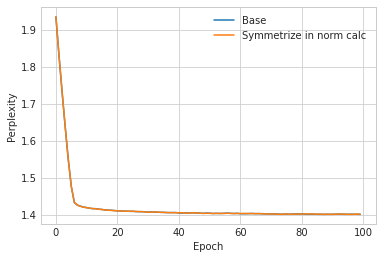

In [ ]:
data = {
    'num_epochs': 100,
    "Base": base_perp,
    "Symmetrize in norm calc": sym_norm_calc_perp,
}
gen_plot(data, y_label='Perplexity')

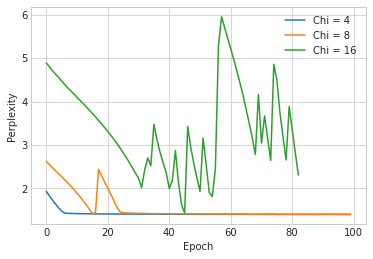

In [ ]:
data = {
    'num_epochs': 100,
    #"Chi = 2": chi2_perp,
    "Chi = 4": base_perp,
    "Chi = 8": chi8_perp,
    "Chi = 16": chi16_perp,
}
gen_plot(data, y_label='Perplexity')